# Learning Position Auctions

In this tutorial, we will extend the ideas from the [previous tutorial](learning-auctions-interdependence.ipynb).  We will consider position auctions, like those found in paid search marketplaces.

## Motivating example

Consider a three-bidder, two-slot position auction where the values for the three bidders are correlated.  There is a signal $c\sim U[0,1]$, which we intepret as a _conversion rate_.  The value of the item for bidder 1 is a random variable $v_1 = x_1 c$ where $x_1 \sim U[0,1]$, similarly for bidder 2 and bidder 3 with independent $x_i \sim U[0,1]$.

The first slot has a click-through-rate (quality) of 1.  The second slot has a click-through-rate of 0.5.  A bidder may purchase one slot only, so we can consider this a special case of a multi-item, unit-demand scenario.

## Architectures and supporting functions

As in the previous tutorial, we will make use of RegretNet.

### Preliminaries

We will make heavy use of numpy, pandas, and pytorch.

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')

We will also make use of matplotlib and seaborn for visualization:

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Common components

All mechanism networks will output allocations and payments.  The allocation shape is `[batch_size, bidders+1]`.  The first column represents the probability that the item is not allocated, with all other columns representing the probability that the item is allocated to the respective bidder.  The payment shape is `[batch_size, bidders]`.  Here each column represents the payment of the respective bidder.

We define a generic mechanism as follows:

In [3]:
class MechanismNet(nn.Module):
    def __init__(self, allocation_rule, payment_rule):
        super(MechanismNet, self).__init__()
        self.allocation_rule = allocation_rule
        self.payment_rule = payment_rule
        
    def forward(self, x):
        allocation = self.allocation_rule(x)
        return allocation, allocation*self.payment_rule(x)
    
    
class MechanismWithSignalsNet(nn.Module):
    def __init__(self, allocation_rule, payment_rule):
        super(MechanismWithSignalsNet, self).__init__()
        self.allocation_rule = allocation_rule
        self.payment_rule = payment_rule
        
    def forward(self, x, signals):
        allocation = self.allocation_rule(x, signals)
        return allocation, allocation*self.payment_rule(x, signals)


Utility can thusly be calculated by:

In [4]:
def calc_utility(bids, mechanism, valuation=None, output_components=False):
    valuation = valuation if valuation is not None else bids
    allocation, payment = mechanism(bids)
    if output_components:
        return allocation*valuation-payment, allocation, payment
    else:
        return allocation*valuation-payment
    
def calc_utility_with_signals(bids, signals, mechanism, valuation=None, output_components=False):
    valuation = valuation if valuation is not None else bids
    allocation, payment = mechanism(bids, signals)
    if output_components:
        return allocation*valuation-payment, allocation, payment
    else:
        return allocation*valuation-payment

The `calc_utility` function will return a tensor of shape `[batch_size,bidders]`.

In order to determine if a mechanism is (approximately) DISC, we calculate regret:

In [5]:
def calc_regret(values, mechanism, responders, leaky=False):
    u_true, a_true, p_true = calc_utility(values, mechanism, output_components=True)
    regret = torch.zeros(values.shape).to(device)
    for bidder, responder in enumerate(responders):
        bidder_mask = torch.zeros(values.shape).to(device)
        bidder_mask[:,bidder] = 1.0
        response = responder(values, a_true, p_true)
        u_response = calc_utility(response, mechanism, values)
        if leaky:
            regret = regret + F.leaky_relu((u_response - u_true) * bidder_mask)
        else:
            regret = regret + F.relu((u_response - u_true) * bidder_mask)
    return regret.mean(dim=0)

def calc_regret_with_signals(values, signals, mechanism, responders, leaky=False):
    u_true, a_true, p_true = calc_utility_with_signals(values, signals, mechanism, output_components=True)
    regret = torch.zeros(values.shape).to(device)
    for bidder, responder in enumerate(responders):
        bidder_mask = torch.zeros(values.shape).to(device)
        bidder_mask[:,bidder] = 1.0
        response = responder(values, a_true, p_true)
        u_response = calc_utility_with_signals(response, signals, mechanism, values)
        if leaky:
            regret = regret + F.leaky_relu((u_response - u_true) * bidder_mask)
        else:
            regret = regret + F.relu((u_response - u_true) * bidder_mask)
    return regret.mean(dim=0)

Finally, we can define the training function.

In [6]:
import torch.optim as optim
import torch.utils.data as data_utils
from tqdm import tqdm

def train(mechanism, responders, values_loader, epochs=1, rho=100, allowable_dsic_violation=0, allowable_ir_violation=0):
    # Initialize augmented lagrangian parameters
    lambda_dsic = torch.zeros(bidders).to(device)
    lambda_ir   = torch.zeros(bidders).to(device)

    # Initalize the optimizer
    mechanism_optimizer = optim.Adam(mechanism.parameters(), lr=1e-4)
    responder_optimizers = [optim.Adam(r.parameters(), lr=1e-4) for r in responders]
    report_data = []

    for epoch in tqdm(range(epochs)):
        for batch_idx,(values_list) in enumerate(values_loader):
            values = values_list[0].to(device)
            
            # calculate the utilities and prices
            utility, allocation, payment = calc_utility(
                values, mechanism, output_components=True)
    
            # compute expected regret 
            dsic_violation = F.relu(calc_regret(
                values, 
                mechanism,
                responders)-allowable_dsic_violation)
    
            # compute individual rationality violation
            ir_violation = F.relu(F.relu(-utility)-allowable_ir_violation).mean(dim=0)
    
            # compute components of the loss function
            revenue = payment.sum(dim=-1).mean()
            total_dsic_violation = dsic_violation.sum()
            total_ir_violation = ir_violation.sum()
    
            # Start the gradient computation
            mechanism.zero_grad()
    
            # define the loss 
            loss = -revenue\
                +(lambda_dsic*dsic_violation).sum()\
                +(lambda_ir*ir_violation).sum()\
                +0.5*rho*(total_dsic_violation.pow(2)+total_ir_violation.pow(2))
    
            # Trigger the autogradient calculation
            loss.backward()
        
            # Take a step towards the gradient
            mechanism_optimizer.step()
            
            with torch.no_grad():
                mechanism.eval()
                for responder in responders:
                    responder.eval()
                    
                # Update the augmented lagrangian parameters
                dsic_violation_next = F.relu(calc_regret(
                    values,
                    mechanism,
                    responders)-allowable_dsic_violation)
                u_next = calc_utility(values, mechanism)
                ir_violation_next = F.relu(F.relu(-u_next)-allowable_ir_violation).mean(dim=0)
                lambda_dsic = lambda_dsic + rho * dsic_violation_next
                lambda_ir = lambda_ir + rho * ir_violation_next
                mechanism.train()
                for responder in responders:
                    responder.train()
            
            report_data.append({
                'epoch': epoch,
                'batch': batch_idx,
                'revenue':revenue.item(),
                'total_dsic_violation':total_dsic_violation.item(),
                'total_ir_violation':total_ir_violation.item(),
                'loss':loss.item()})
            
            for bidder, responder in enumerate(responders):
                optimizer = responder_optimizers[bidder]
                optimizer.zero_grad()
                regret = calc_regret(
                    values, 
                    mechanism,
                    responders,
                    leaky=True)
                (-regret[bidder]).backward()
                optimizer.step()
            
    return pd.DataFrame(report_data)

def train_with_signals(mechanism, responders, values_and_signals_loader, epochs=1, rho=100, allowable_dsic_violation=0, allowable_ir_violation=0):
    # Initialize augmented lagrangian parameters
    lambda_dsic = torch.zeros(bidders).to(device)
    lambda_ir   = torch.zeros(bidders).to(device)

    # Initalize the optimizer
    mechanism_optimizer = optim.Adam(mechanism.parameters(), lr=1e-4)
    responder_optimizers = [optim.Adam(r.parameters(), lr=1e-4) for r in responders]
    report_data = []

    for epoch in tqdm(range(epochs)):
        for batch_idx,(values_list) in enumerate(values_and_signals_loader):
            values = values_list[0].to(device)
            signals = values_list[1].to(device)
            
            # calculate the utilities and prices
            utility, allocation, payment = calc_utility_with_signals(
                values, signals, mechanism, output_components=True)
    
            # compute expected regret 
            dsic_violation = F.relu(calc_regret_with_signals(
                values,
                signals,
                mechanism,
                responders)-allowable_dsic_violation)
    
            # compute individual rationality violation
            ir_violation = F.relu(F.relu(-utility)-allowable_ir_violation).mean(dim=0)
    
            # compute components of the loss function
            revenue = payment.sum(dim=-1).mean()
            total_dsic_violation = dsic_violation.sum()
            total_ir_violation = ir_violation.sum()
    
            # Start the gradient computation
            mechanism.zero_grad()
    
            # define the loss 
            loss = -revenue\
                +(lambda_dsic*dsic_violation).sum()\
                +(lambda_ir*ir_violation).sum()\
                +0.5*rho*(total_dsic_violation.pow(2)+total_ir_violation.pow(2))
    
            # Trigger the autogradient calculation
            loss.backward()
        
            # Take a step towards the gradient
            mechanism_optimizer.step()
            
            with torch.no_grad():
                mechanism.eval()
                for responder in responders:
                    responder.eval()
                    
                # Update the augmented lagrangian parameters
                dsic_violation_next = F.relu(calc_regret_with_signals(
                    values,
                    signals,
                    mechanism,
                    responders)-allowable_dsic_violation)
                u_next = calc_utility_with_signals(values, signals, mechanism)
                ir_violation_next = F.relu(F.relu(-u_next)-allowable_ir_violation).mean(dim=0)
                lambda_dsic = lambda_dsic + rho * dsic_violation_next
                lambda_ir = lambda_ir + rho * ir_violation_next
                mechanism.train()
                for responder in responders:
                    responder.train()
            
            report_data.append({
                'epoch': epoch,
                'batch': batch_idx,
                'revenue':revenue.item(),
                'total_dsic_violation':total_dsic_violation.item(),
                'total_ir_violation':total_ir_violation.item(),
                'loss':loss.item()})
            
            for bidder, responder in enumerate(responders):
                optimizer = responder_optimizers[bidder]
                optimizer.zero_grad()
                regret = calc_regret_with_signals(
                    values,
                    signals,
                    mechanism,
                    responders,
                    leaky=True)
                (-regret[bidder]).backward()
                optimizer.step()
            
    return pd.DataFrame(report_data)   

Now, we pre-compute the outcomes for each feasible slot configuration using the following number of bidders:

In [7]:
bidders = 3
slots = 2

# Clicks for no-allocation,
# Clicks for first slot
# Clicks for second slot
click_curve = torch.tensor([[1, 0.5, 0]]).float().to(device)

def bidders_to_index(allocated_bidders):
    idx = [bidders-1] * bidders
    for i,p in enumerate(allocated_bidders):
        idx[p] = i
    return idx

all_bidders = set(range(bidders))
curve_indices = [[bidders-1] * bidders] # initialize to empty slate

for b1 in all_bidders:
    curve_indices.append(bidders_to_index([b1]))

for b1 in all_bidders:
    for b2 in all_bidders - set([b1]):
        curve_indices.append(bidders_to_index([b1,b2]))

outcomes = click_curve[0,curve_indices]
outcome_count = outcomes.shape[0]

In [8]:
outcomes.shape

torch.Size([10, 3])

## Responder

The responder network computes the best response to the mechanism.

In [9]:
class Responder(nn.Module):
    def __init__(self, bidder, hidden_units):
        super(Responder, self).__init__()
        self.bidder = bidder
        self.initial_layer = nn.Linear(2, hidden_units)
        self.hidden_layer = nn.Linear(hidden_units, hidden_units)
        self.final_layer = nn.Linear(hidden_units, 1)
        
    def forward(self, values, allocation, payment):
        x = torch.cat((allocation[:,self.bidder].unsqueeze(1), payment[:,self.bidder].unsqueeze(1)), dim=1)
        x = F.leaky_relu(self.initial_layer(x))
        x = F.leaky_relu(self.hidden_layer(x))
        x = torch.sigmoid(self.final_layer(x))
        bidder_mask = torch.zeros(values.shape).to(device)
        bidder_mask[:,self.bidder] = 1.0
        return (1-bidder_mask)*values + bidder_mask * values * x

## GSP

For comparison, we define the GSP mechanism.

In [10]:
class GspAllocation:
    def __call__(self, x):
        idx = x.argsort(dim=1, descending=True)
        return click_curve.repeat([x.shape[0], 1]).gather(dim=1, index=idx)
    
class GspPayment:
    def __call__(self, x):
        ordered_x = x.sort(dim=1, descending=True)[0]
        ordered_x[:,0:(bidders-1)] = ordered_x[:,1:bidders]
        ordered_x[:,-1] = 0
        idx = x.argsort(dim=1, descending=True)
        return ordered_x.gather(dim=1, index=idx)
    
def create_gsp_mechanism():
    return MechanismNet(
        GspAllocation(),
        GspPayment())

def run_gsp(mechanism, responders, values_loader, epochs=1, rho=100):
    # Initalize the optimizer
    responder_optimizers = [optim.Adam(r.parameters(), lr=1e-4) for r in responders]
    report_data = []

    for epoch in tqdm(range(epochs)):
        for batch_idx,(values_list) in enumerate(values_loader):
            values = values_list[0].to(device)
            
            # calculate the utilities and prices
            utility, allocation, payment = calc_utility(
                values, mechanism, output_components=True)
    
            # compute expected regret 
            dsic_violation = calc_regret(
                values, 
                mechanism,
                responders)
    
            # compute individual rationality violation
            ir_violation = F.relu(-utility).mean(dim=0)
    
            # compute components of the loss function
            revenue = payment.sum(dim=-1).mean()
            total_dsic_violation = dsic_violation.sum()
            total_ir_violation = ir_violation.sum()
            
            report_data.append({
                'epoch': epoch,
                'batch': batch_idx,
                'revenue':revenue.item(),
                'total_dsic_violation':total_dsic_violation.item(),
                'total_ir_violation':total_ir_violation.item()})
            
            for bidder, responder in enumerate(responders):
                optimizer = responder_optimizers[bidder]
                optimizer.zero_grad()
                regret = calc_regret(
                    values, 
                    mechanism,
                    responders,
                    leaky=True)
                (-regret[bidder]).backward()
                optimizer.step()
            
    return pd.DataFrame(report_data)

## RegretNet

The allocation network is defined as follows:

In [11]:
class RegretNetAllocation(nn.Module):
    def __init__(self, bidders, hidden_layers, hidden_units):
        super(RegretNetAllocation, self).__init__()
        assert hidden_layers > 0
        fc_layers = []
        fc_layers.append(nn.Linear(bidders, hidden_units))
        if hidden_layers > 1:
            for _ in range(hidden_layers-1):
                fc_layers.append(nn.Linear(hidden_units, hidden_units))
        fc_layers.append(nn.Linear(hidden_units, outcome_count))
        self.fc_layers = nn.ModuleList(fc_layers)
        
    def forward(self, x):
        for layer in self.fc_layers[:-1]:
            x = F.leaky_relu(layer(x))
        x = F.softmax(self.fc_layers[-1](x), dim=1)
        return torch.mm(x,outcomes)
    
class RegretWithSignalsNetAllocation(nn.Module):
    def __init__(self, bidders, signal_count, hidden_layers, hidden_units):
        super(RegretWithSignalsNetAllocation, self).__init__()
        assert hidden_layers > 0
        fc_layers = []
        fc_layers.append(nn.Linear(bidders+signal_count, hidden_units))
        if hidden_layers > 1:
            for _ in range(hidden_layers-1):
                fc_layers.append(nn.Linear(hidden_units, hidden_units))
        fc_layers.append(nn.Linear(hidden_units, outcome_count))
        self.fc_layers = nn.ModuleList(fc_layers)
        
    def forward(self, x, signals):
        x = torch.cat((x,signals), dim=1)
        for layer in self.fc_layers[:-1]:
            x = F.leaky_relu(layer(x))
        x = F.softmax(self.fc_layers[-1](x), dim=1)
        return torch.mm(x,outcomes)

The payment network is defined as follows:

In [12]:
class RegretNetPayment(nn.Module):
    def __init__(self, bidders, hidden_layers, hidden_units):
        super(RegretNetPayment, self).__init__()
        assert hidden_layers > 0
        fc_layers = []
        fc_layers.append(nn.Linear(bidders, hidden_units))
        if hidden_layers > 1:
            for _ in range(hidden_layers-1):
                fc_layers.append(nn.Linear(hidden_units, hidden_units))
        fc_layers.append(nn.Linear(hidden_units, bidders))
        self.fc_layers = nn.ModuleList(fc_layers)
        
    def forward(self, x):
        for layer in self.fc_layers:
            x = F.leaky_relu(layer(x))
        return x
    
class RegretWithSignalsNetPayment(nn.Module):
    def __init__(self, bidders, signal_count, hidden_layers, hidden_units):
        super(RegretWithSignalsNetPayment, self).__init__()
        assert hidden_layers > 0
        fc_layers = []
        fc_layers.append(nn.Linear(bidders+signal_count, hidden_units))
        if hidden_layers > 1:
            for _ in range(hidden_layers-1):
                fc_layers.append(nn.Linear(hidden_units, hidden_units))
        fc_layers.append(nn.Linear(hidden_units, bidders))
        self.fc_layers = nn.ModuleList(fc_layers)
        
    def forward(self, x, signals):
        x = torch.cat((x,signals), dim=1)
        for layer in self.fc_layers:
            x = F.leaky_relu(layer(x))
        return x

Finally, we can define the RegretNet mechanism:

In [13]:
def create_regret_net(bidders, hidden_layers=2, hidden_units=100):
    return MechanismNet(
        RegretNetAllocation(bidders, hidden_layers, hidden_units),
        RegretNetPayment(bidders, hidden_layers, hidden_units))

def create_regret_net_with_signals(bidders, signal_count, hidden_layers=2, hidden_units=100):
    return MechanismWithSignalsNet(
        RegretWithSignalsNetAllocation(bidders, signal_count, hidden_layers, hidden_units),
        RegretWithSignalsNetPayment(bidders, signal_count, hidden_layers, hidden_units))

## Auction for the motivating example



The networks will train on data that is sampled from the value distribution, which is loaded into a `DataLoader`.

In [14]:
sample_size = 2**11
batch_size = 2**8
epochs = 1000

indepedent_components = torch.rand(sample_size, bidders)
common_components = torch.rand(sample_size, 1)
values = indepedent_components * common_components

values_loader=data_utils.DataLoader(
    data_utils.TensorDataset(values),
    batch_size=batch_size)

values_and_signals_loader=data_utils.DataLoader(
    data_utils.TensorDataset(values, common_components),
    batch_size=batch_size)

Before training the networks, let's establish a GSP baseline.

In [15]:
gsp_responders = [Responder(bidder, 100).to(device) for bidder in range(bidders)]
gsp = create_gsp_mechanism()
gsp_report = run_gsp(gsp, gsp_responders, values_loader, epochs=epochs)

100%|██████████| 1000/1000 [05:07<00:00,  3.00it/s]


We now create a simple RegretNet and RegretWithSignalsNet instances.

In [16]:
regret_net = create_regret_net(bidders).to(device)
regret_net_with_signals = create_regret_net_with_signals(bidders, 1).to(device)
regret_net_responders = [Responder(bidder, 100).to(device) for bidder in range(bidders)]
regret_net_with_signals_responders = [Responder(bidder, 100).to(device) for bidder in range(bidders)]

We loop over the data for a number of epochs and record traces of the networks learning.

In [17]:
regret_net_report = train(regret_net, regret_net_responders, values_loader, epochs=epochs)
regret_net_with_signals_report = train_with_signals(regret_net_with_signals, regret_net_with_signals_responders, values_and_signals_loader, epochs=epochs)

100%|██████████| 1000/1000 [12:02<00:00,  3.74it/s]


Next, let's review the DSIC violations of the network. In the figure below, we can see that networks have a large initial violation then quickly finds a region with low and decreasing violation.

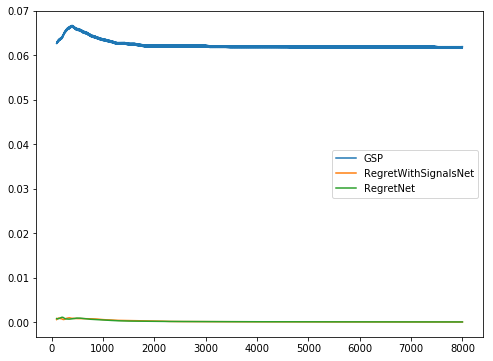

In [18]:
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(gsp_report[['total_dsic_violation']].rolling(100).mean(), label='GSP');
ax.plot(regret_net_with_signals_report[['total_dsic_violation']].rolling(100).mean(), label='RegretWithSignalsNet');
ax.plot(regret_net_report[['total_dsic_violation']].rolling(100).mean(), label='RegretNet');
ax.legend();

Let's review the revenue of the networks.  Both RegretNet and RegretWithSignalsNet approach GSP revenue with less violation.

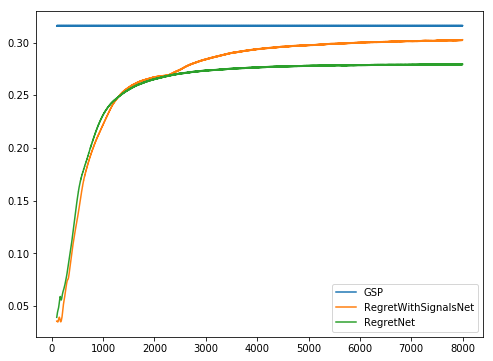

In [19]:
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(gsp_report[['revenue']].rolling(100).mean(), label='GSP');
ax.plot(regret_net_with_signals_report[['revenue']].rolling(100).mean(), label='RegretWithSignalsNet');
ax.plot(regret_net_report[['revenue']].rolling(100).mean(), label='RegretNet');
ax.legend();

Let's retain and allow the same violation as GSP has.

In [20]:
regret_net = create_regret_net(bidders).to(device)
regret_net_with_signals = create_regret_net_with_signals(bidders, 1).to(device)
regret_net_responders = [Responder(bidder, 100).to(device) for bidder in range(bidders)]
regret_net_with_signals_responders = [Responder(bidder, 100).to(device) for bidder in range(bidders)]

Determing the GSP violation, so we can use it as a bound for RegretNet.

In [21]:
minimim_gsp_violation = gsp_report['total_dsic_violation'].rolling(100).mean().min()

Re-train RegetNet with the GSP violation slack.

In [22]:
regret_net_report_with_violation = train(regret_net, regret_net_responders, values_loader, epochs=epochs, allowable_dsic_violation=minimim_gsp_violation)
regret_net_with_signals_report_with_violation = train_with_signals(regret_net_with_signals, regret_net_with_signals_responders, values_and_signals_loader, epochs=epochs, allowable_dsic_violation=minimim_gsp_violation)

100%|██████████| 1000/1000 [10:36<00:00,  1.24it/s]


Now we see that, with the same violation levels as GSP, RegretNet dramatically outperforms in revenue.

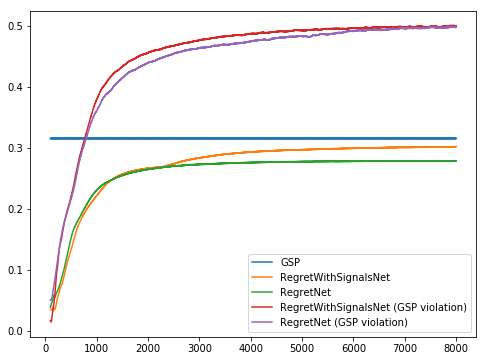

In [23]:
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(gsp_report[['revenue']].rolling(100).mean(), label='GSP');
ax.plot(regret_net_with_signals_report[['revenue']].rolling(100).mean(), label='RegretWithSignalsNet');
ax.plot(regret_net_report[['revenue']].rolling(100).mean(), label='RegretNet');
ax.plot(regret_net_with_signals_report_with_violation[['revenue']].rolling(100).mean(), label='RegretWithSignalsNet (GSP violation)');
ax.plot(regret_net_report_with_violation[['revenue']].rolling(100).mean(), label='RegretNet (GSP violation)');
ax.legend();